In [229]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [230]:
# Reading the final dataset

df=pd.read_csv("finaldata.csv")
df.head()

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,1.22.35.226,6,6.0,6,6,1.338050e+04,1.943990e+04,7.000000
1,100.2.4.116,6,3.0,6,6,1.811173e+07,2.803655e+07,1201.666667
2,100.43.83.137,84,21.0,84,56,1.505974e+04,1.469133e+04,2485.226190
3,101.119.18.35,33,33.0,33,32,7.144242e+04,1.136064e+05,1.696970
4,101.199.108.50,3,3.0,3,3,1.460800e+04,2.029127e+04,5.000000


# K-Means Clustering Algorithm

In [231]:
# Features chosen for the model 

chosen_data = df[['Total Requests', 'Daily Mean', 'GET requests',
       'Successful requests', 'Mean Return Size', 'Return Size Std',
       'Mean Time Difference']]

In [232]:
# Scalling all features to lie between 0 and 1 using MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(chosen_data)
chosen_data = pd.DataFrame(np_scaled, columns=chosen_data.columns)

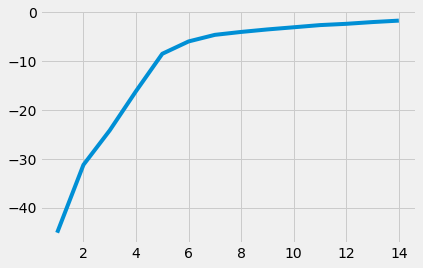

In [233]:
# Creating elbow plot to identify optimal number of clusters

n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i, random_state=42).fit(chosen_data) for i in n_cluster]
scores = [kmeans[i].score(chosen_data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [234]:
# Assigning cluster number to each data point

cluster_model = kmeans[4]
df['cluster'] = cluster_model.predict(chosen_data)
df['cluster'].value_counts()

0    1657
1      63
2      15
3      14
4       4
Name: cluster, dtype: int64

In [235]:
# Visualising multidimensional data in 2D plane

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(chosen_data)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [236]:
# Finding cluster centroids 

tsne_cluster = df.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()

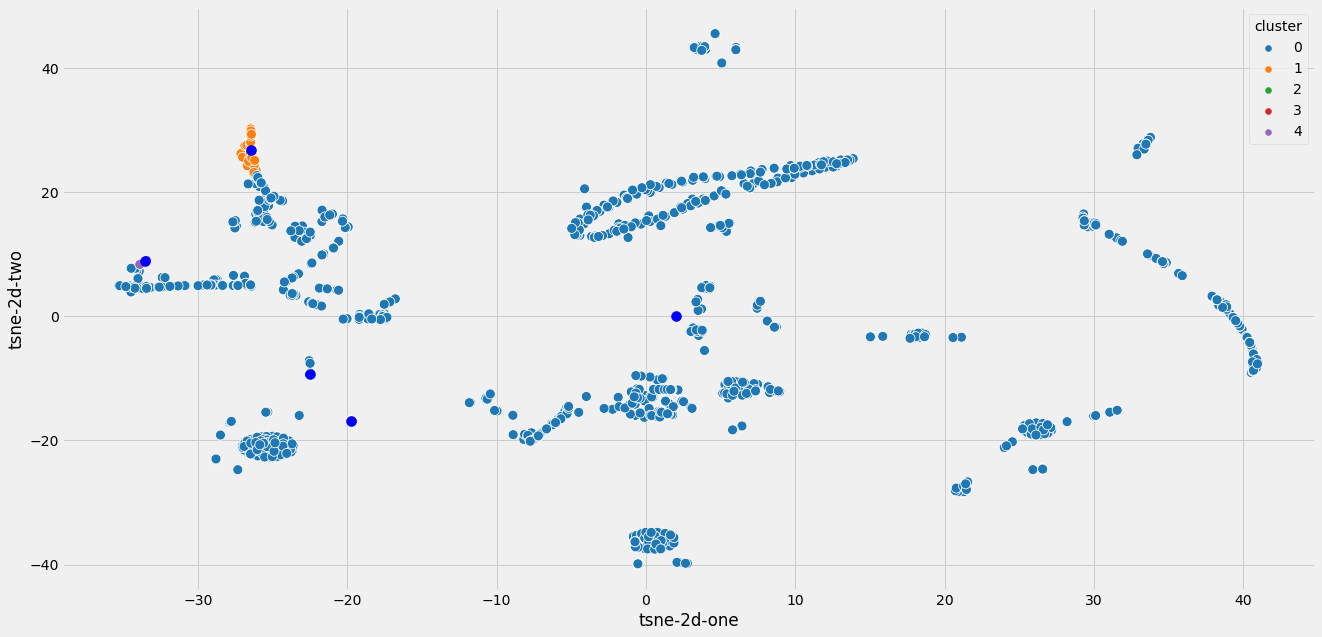

In [237]:
# Plotting 2D Scatterplot visualisation coloured according to cluster

plt.figure(figsize=(20,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df,
    hue="cluster",
    palette=sns.color_palette("tab10", 5),
    legend="full",
    alpha=1,
    s=100
)

plt.scatter(x="tsne-2d-one", y="tsne-2d-two", data=tsne_cluster, s=100, c='b')

plt.show()

In [238]:
# Function to calculate sum of squared distance between each data point and centroid

def get_sum_square_distance(data, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[chosen_data.columns])
    total_distance = pd.Series(dtype='float64')
    for i in range(len(points)):
        distance = 0
        for j in range(len(centers)):
            a = np.linalg.norm(points[i] - centers[j])
            distance += a**2
        total_distance.at[i]= distance
    
    return total_distance

df['ssd'] = get_sum_square_distance(chosen_data, cluster_model)

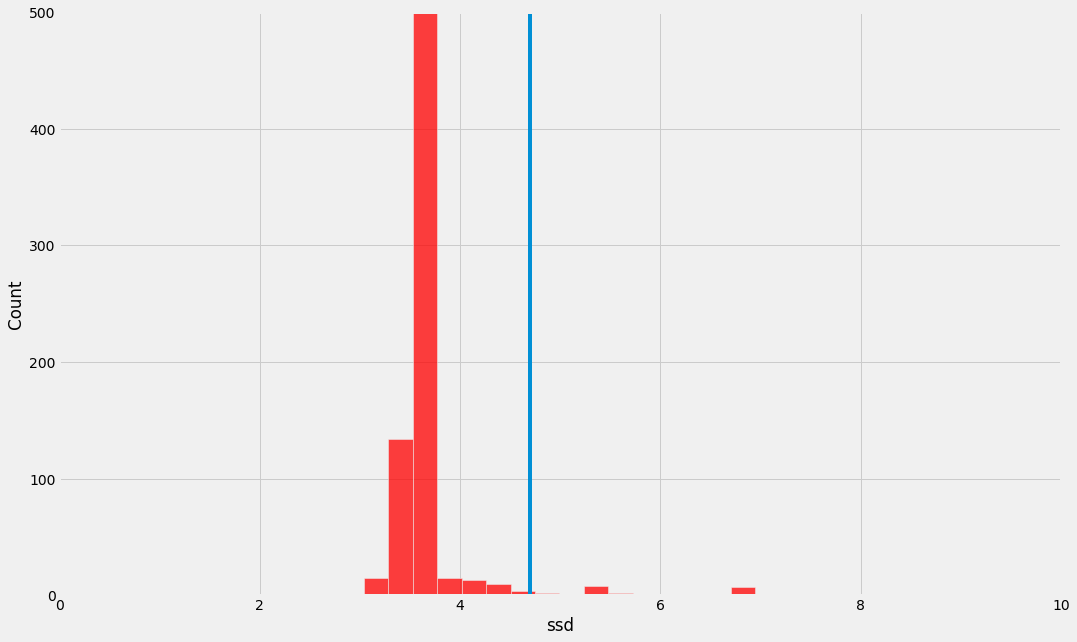

In [239]:
# Ploting histogram on sum of squared distance to find cutoff for anomalous requests

plt.figure(figsize=(16,10))
histo = sns.histplot(data=df,x="ssd",bins=50,color='red')
histo.set(xlim=(0,10),ylim=(0,500))
plt.axvline(4.7, 0, label="Cutoff")

In [240]:
# Labelling KMean Anomalies 

cutoff = 4.7
df['anomaly_kmeans'] = (df['ssd'] >= cutoff).astype(int)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

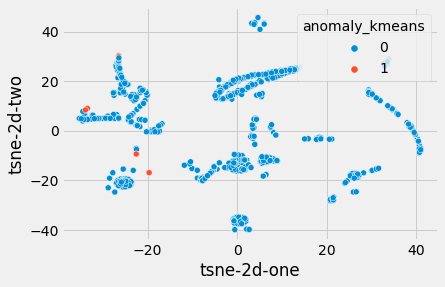

In [241]:
# Scatterplot visualisation of anomalous requests

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_kmeans",
    data=df,
    legend="full",
    alpha=1
)

In [259]:
# Number of API misuse/abuse detected:

len(df[df['anomaly_kmeans']==1])

29

# Isolated forests

In [244]:
# outlier_fraction = 0.028
outlier_fraction = len(df[df['anomaly_kmeans']==1])/len(df)
print(outlier_fraction)
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=0.01)

0.01654306902452938


In [245]:
model.fit(chosen_data)

IsolationForest(contamination=0.01, max_features=3, n_estimators=200, n_jobs=-1,
                random_state=42)

In [246]:
df['anomaly_isolated'] = pd.Series(model.predict(chosen_data))

In [247]:
df['anomaly_isolated'] = df['anomaly_isolated'].map( {1: 0, -1: 1} )
df['anomaly_isolated'].value_counts()

0    1735
1      18
Name: anomaly_isolated, dtype: int64

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

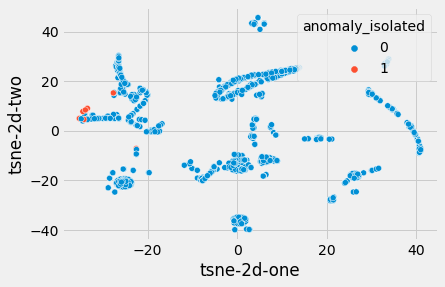

In [248]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
    data=df,
    legend="full",
    alpha=1
)

In [249]:
df.loc[df['anomaly_isolated']==1].head()

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated
2,100.43.83.137,84,21.00,84,56,15059.738095,14691.328815,2485.226190,0,-34.084259,7.460135,3.182848,0,1
202,130.237.218.86,357,178.50,357,288,123026.971989,316026.422649,202.005602,4,-33.455757,9.016716,11.718255,1,1
226,14.160.65.22,50,50.00,50,48,51559.880000,96587.387992,73.100000,0,-35.227322,4.936681,3.327580,0,1
703,198.46.149.143,82,20.50,82,82,10036.000000,724.430811,3205.597561,0,-34.131222,7.540218,3.194543,0,1
830,208.115.111.72,83,20.75,83,82,10545.253012,18201.128339,2429.759036,0,-34.123703,7.526203,3.194601,0,1


# One Class SVM

In [250]:
model1 =  OneClassSVM(nu=outlier_fraction, degree=2, kernel='rbf')

In [251]:
data_new_clean = chosen_data.loc[chosen_data['Total Requests'] <=chosen_data['Total Requests'].quantile(1-outlier_fraction)]

In [252]:
model1.fit(data_new_clean)

OneClassSVM(degree=2, nu=0.01654306902452938)

In [253]:
df['anomaly_svm'] = pd.Series(model.predict(chosen_data))

In [254]:
df['anomaly_svm'] = df['anomaly_svm'].map( {1: 0, -1: 1} )
df['anomaly_svm'].value_counts()

0    1735
1      18
Name: anomaly_svm, dtype: int64

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

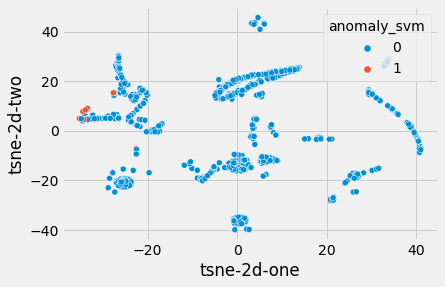

In [255]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_svm",
    data=df,
    legend="full",
    alpha=1
)

In [256]:
df.loc[df['anomaly_svm']==1]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated,anomaly_svm
2,100.43.83.137,84,21.000000,84,56,1.505974e+04,1.469133e+04,2485.226190,0,-34.084259,7.460135,3.182848,0,1,1
202,130.237.218.86,357,178.500000,357,288,1.230270e+05,3.160264e+05,202.005602,4,-33.455757,9.016716,11.718255,1,1,1
226,14.160.65.22,50,50.000000,50,48,5.155988e+04,9.658739e+04,73.100000,0,-35.227322,4.936681,3.327580,0,1,1
703,198.46.149.143,82,20.500000,82,82,1.003600e+04,7.244308e+02,3205.597561,0,-34.131222,7.540218,3.194543,0,1,1
830,208.115.111.72,83,20.750000,83,82,1.054525e+04,1.820113e+04,2429.759036,0,-34.123703,7.526203,3.194601,0,1,1
831,208.115.113.88,74,24.666667,74,70,7.462284e+03,1.193013e+04,2093.662162,0,-34.090214,7.413974,3.180934,0,1,1
850,209.85.238.199,102,25.500000,102,102,2.516038e+04,1.030578e+04,2682.598039,0,-34.180161,7.678838,3.250097,0,1,1
905,216.152.249.242,25,12.500000,25,22,1.952298e+06,9.684378e+06,2.240000,0,-22.530098,-7.139191,3.205742,0,1,1
917,217.195.202.13,23,23.000000,23,22,2.122794e+06,1.009621e+07,158.913043,0,-22.543756,-7.138674,3.186947,0,1,1
1040,46.105.14.53,364,91.000000,364,364,1.487200e+04,0.000000e+00,791.447802,4,-33.458847,9.017339,10.022202,1,1,1
